# Ciclo 2 - Desenvolvimento

**Identificar a melhor forma de extração de features; o melhor algoritmo; e o melhor conjunto de hiper-parâmetros para cada algoritmo;**

- Avalia, em uma amostra reduzida do conjunto de dados, se existe diferença significativa de performance quando utilizamos apenas o título em comparação com utilizarmos apenas o resumo.

- Avalia se existe diferença significativa de performance retirando as palavras que se repetem mais vezes nos documentos.

- Investiga a diferença de acurácia média balanceada quando utilizamos TF-IDF + LSA, e quando utilizamos apenas o TF-IDF. Avaliando também o tempo para extração das features e o tempo de treinamento de cada algoritmo.

- Avalia se a posição relativa dos algoritmos no ranking se mantém consistente conforme aumentamos a quantidade de observações utilizadas no treinamento. Utiliza amostras do conjunto de dados com 1.000, 2.000, 5.000, 10.000, 15.000 e 20.000 observações.

> Para o treinamento será utilizado o esquema de validação cruzada, no qual todo o conjunto de dados é utilizado como dado de treinamento e também de testes, utilizando-se várias rodadas com amostras de teste e treinamento que vão sendo alteradas a cada rodada, até todas as observações terem sido usadas tanto para treinar como para testar o classificador. 

> Para avaliar a conjectura sobre a possibilidade de aumentar a acurácia com ajustes nos hiper-parâmetros, além do esquema de validação cruzada, vamos utilizar um função implementada na biblioteca Sci-kit Learn \citep{scikit-learn} pela classe sklearn.model\_selection.GridSearchCV que executa o \textit{Cross Validation} a partir de um conjunto pré-definido de hiper-parâmetros, identificando o ajuste que obtém a melhor performance. Ao final do processo o classificador (ajuste de hiper-parâmetros) que tiver atingido a melhor performance (acurácia) é treinado com todos os dados.

> Para aferir a performance esperada, utiliza uma etapa de validação, com dados não utilizados nas fases anteriores. Isso é possível porque mesmo a maior amostra de dados (20.000 observações) representa menos de 10\% do total de observações disponíveis no conjunto de dados completo.

> Utilizaremos a acurácia média balanceada como métrica de performance para comparar os classificadores e identificar o melhor para nosso trabalho. 

In [1]:
import os
import re
import sys
sys.path.append('../')
from machine_learning import ENV, load_obj

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_theme(style="whitegrid", color_codes=True)


kinds = ['strip', 'swarm', 'box', 'violin', 'boxen', 'point', 'bar']


def ranking(engine='catplot', **kwargs):
    centimeters = 20
    height = centimeters/2.54
    if engine == 'catplot':
        g = sns.catplot(**kwargs, height=height, palette='colorblind');
    elif engine == 'lineplot':
        plt.figure(figsize=(centimeters, centimeters/2));
        g = sns.lineplot(**kwargs, palette='colorblind');
    elif engine == 'lmplot':
        g = sns.lmplot(**kwargs, height=height, palette='colorblind');
    elif engine == 'relplot':
        g = sns.relplot(**kwargs, height=height, palette='colorblind');
    plt.savefig(os.path.join(ENV['CACHE_FOLDER'], f'ranking_{kwargs.get("kind", engine)}_{kwargs["y"]}_by_{kwargs["x"]}+{kwargs["hue"]}_per_{kwargs.get("row", "")}_{kwargs.get("col", "")}{ENV["PLT_EXT"]}'));


## Dados

In [2]:
# Importing Development Experiments folds results and creating summary
results = pd.DataFrame()
for filename in os.listdir(ENV['CACHE_FOLDER']):
    match = re.search('(^results_cycle2_.*_(073158|225657))\.joblib\.z$', filename)
    if match:
        filename = match.group(1)
        _, *experiment_name, date, time = filename.split('_')
        experiment_id = '_'.join(experiment_name)
        
        df_ = pd.DataFrame(load_obj(filename))
        results = pd.concat([results, df_])
        
        print(f'Imported {_} from experiment: {experiment_id}, ran: {date}|{time}')

results.insert(2, "feature_type", 
               results.apply(lambda row: 'tfidf' if row['X_n_dims'] == 0 else f'lsa_{row["X_n_dims"]}',
                             axis=1))
results = results.astype({
    'train_observations': 'int32',
    'random_seed': 'int32',
    'max_df': 'float',
    'n_grams': 'int32',
    'X_n_dims': 'int32',
    'hyperparams': 'str'
})
summary = results.drop_duplicates(subset=['X_column', 'train_observations', 'estimator',
                                          'feature_type', 'max_df'])
# Report
print(2 * '\n')
print(f'Results shape: {results.shape} ==> all data')
print(f'Summary shape: {summary.shape} ==> only unique validated_mean_Accuracy')
print(2 * '\n')
results.columns
print(2 * '\n')


# Importing Development Experiments epochs results
bert_results = pd.DataFrame()
for filename in os.listdir(ENV['CACHE_FOLDER']):
    match = re.search('^epochs_(.*(5000|10000))\.csv$', filename)
    if match:
        epoch_id = match.group(1)
        *model_name, max_seq, lr, n_samples = epoch_id.split('_')
        
        df_ = pd.read_csv(os.path.join(ENV['CACHE_FOLDER'], match.group(0)))
        df_.rename(columns={df_.columns[0]: 'epoch'}, inplace=True)
        df_['model'] = '_'.join(model_name)
        df_['max_seq'] = int(max_seq)
        df_['learning_rate'] = float(f'1e-{int(lr[-1])}')
        df_['n_samples'] = int(n_samples)
        bert_results = pd.concat([bert_results, df_])
        
        print(f'Imported epochs from experiment: {epoch_id}')

bert_results.reset_index(drop=True, inplace=True)
print(2 * '\n')
bert_results.columns


# Persist
results.to_csv('development_folds_results.csv', sep='|', index=False)
summary.to_csv('development_folds_summary.csv', sep='|', index=False)
bert_results.to_csv('development_epochs_results.csv', sep='|', index=False)

Imported results from experiment: cycle2_estimators, ran: 20220605|073158
Imported results from experiment: cycle2_features, ran: 20220527|225657



Results shape: (2208, 29) ==> all data
Summary shape: (126, 29) ==> only unique validated_mean_Accuracy





Index(['estimator', 'X_n_dims', 'feature_type', 'X_column', 'n_grams',
       'max_df', 'random_seed', 'train_observations', 'hyperparams',
       'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'best_mean_Accuracy', 'validated_mean_Accuracy',
       'validated_confusion_matrix', 'validated_f1score_weighted',
       'test_Accuracy', 'mean_Accuracy', 'std_Accuracy', 'test_F1score',
       'mean_F1score', 'std_F1score', 'test_Precision', 'mean_Precision',
       'std_Precision', 'test_Recall', 'mean_Recall', 'std_Recall'],
      dtype='object')




Imported epochs from experiment: bertimbau_base_194_LR2_5000
Imported epochs from experiment: bertimbau_base_194_LR2_10000
Imported epochs from experiment: bertimbau_base_194_LR3_5000
Imported epochs from experiment: bertimbau_base_194_LR3_10000
Imported epochs from experiment: bertimbau_base_194_LR4_5000
Imported epochs from experiment: bertimbau_base_194_LR4_10000
Imported epochs from experiment: bertimbau_base_194_LR5_5000
Imported epochs from experiment: bertimbau_base_194_LR5_10000





Index(['epoch', 'train_loss', 'valid_loss', 'train_accs', 'valid_accs',
       'model', 'max_seq', 'learning_rate', 'n_samples'],
      dtype='object')

## Melhor resultado por tipo de feature e algoritmo

In [28]:
overall_ranking = summary.groupby([
    'estimator', 'feature_type'
]).agg({
    'mean_Accuracy': 'max',
    'validated_mean_Accuracy': 'max',
    'mean_F1score': 'max',
    'validated_f1score_weighted': 'max'
    }).round(4)*100
general_view = overall_ranking.sort_values(by='validated_mean_Accuracy', ascending=False)
general_view

mean_Accuracy  validated_mean_Accuracy  mean_F1score  \
estimator feature_type                                                         
svm       tfidf         56.55          57.88                    59.45          
mlp       lsa_1000      47.59          55.64                    49.74          
svm       lsa_1000      54.60          55.62                    57.53          
mlp       tfidf         44.74          54.51                    48.25          
nbg       lsa_1000      43.79          42.72                    43.27          
          tfidf         33.78          34.15                    36.73          

                        validated_f1score_weighted  
estimator feature_type                              
svm       tfidf         60.70                       
mlp       lsa_1000      58.11                       
svm       lsa_1000      58.45                       
mlp       tfidf         57.47                       
nbg       lsa_1000      41.92                       
          tfidf         35.82

### Código Latex para montar a tabela acima

In [4]:
print(general_view.to_latex())

\begin{tabular}{llrrrr}
\toprule
    &       &  mean\_Accuracy &  validated\_mean\_Accuracy &  mean\_F1score &  validated\_f1score\_weighted \\
estimator & feature\_type &                &                          &               &                             \\
\midrule
svm & tfidf &  56.55 &  57.88 &  59.45 &  60.70 \\
    & lsa\_1000 &  54.60 &  55.62 &  57.53 &  58.45 \\
mlp & lsa\_1000 &  47.59 &  55.64 &  49.74 &  58.11 \\
    & tfidf &  44.74 &  54.51 &  48.25 &  57.47 \\
nbg & lsa\_1000 &  43.79 &  42.72 &  43.27 &  41.92 \\
    & tfidf &  33.78 &  34.15 &  36.73 &  35.82 \\
\bottomrule
\end{tabular}



## Experimento - Features

In [5]:
kind = 'swarm'
y = 'test_Accuracy'
data = results[results['train_observations'].between(1000, 5000)]

### Título ou Resumo ou Título + Resumo?

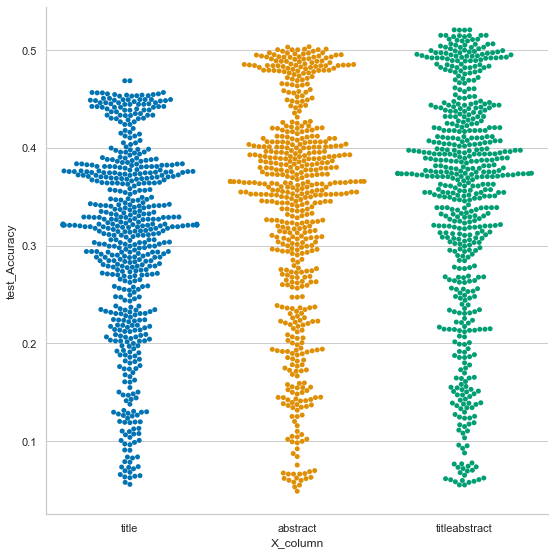

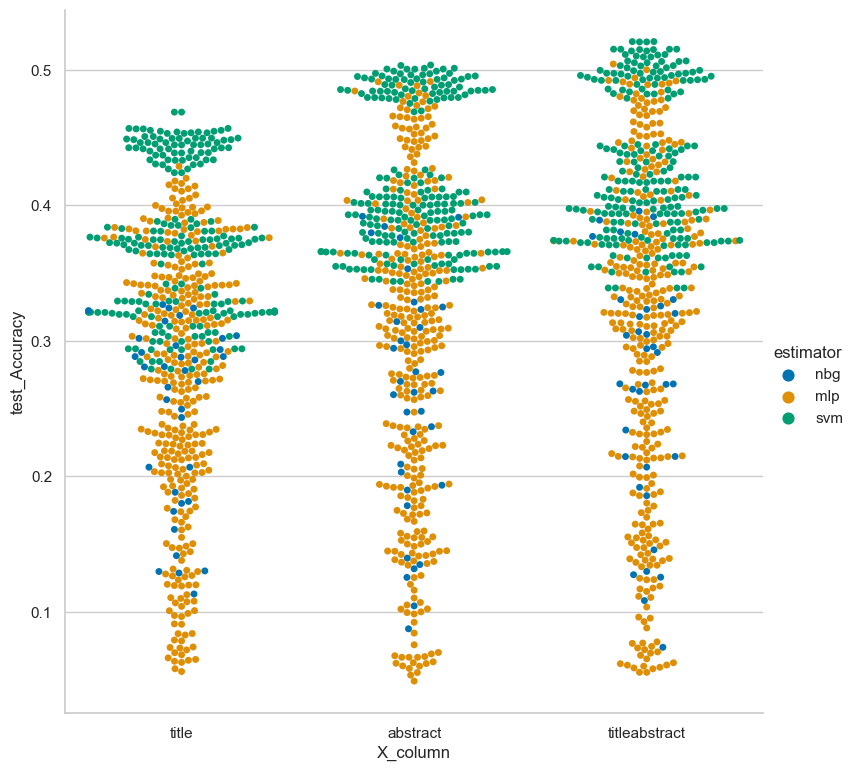

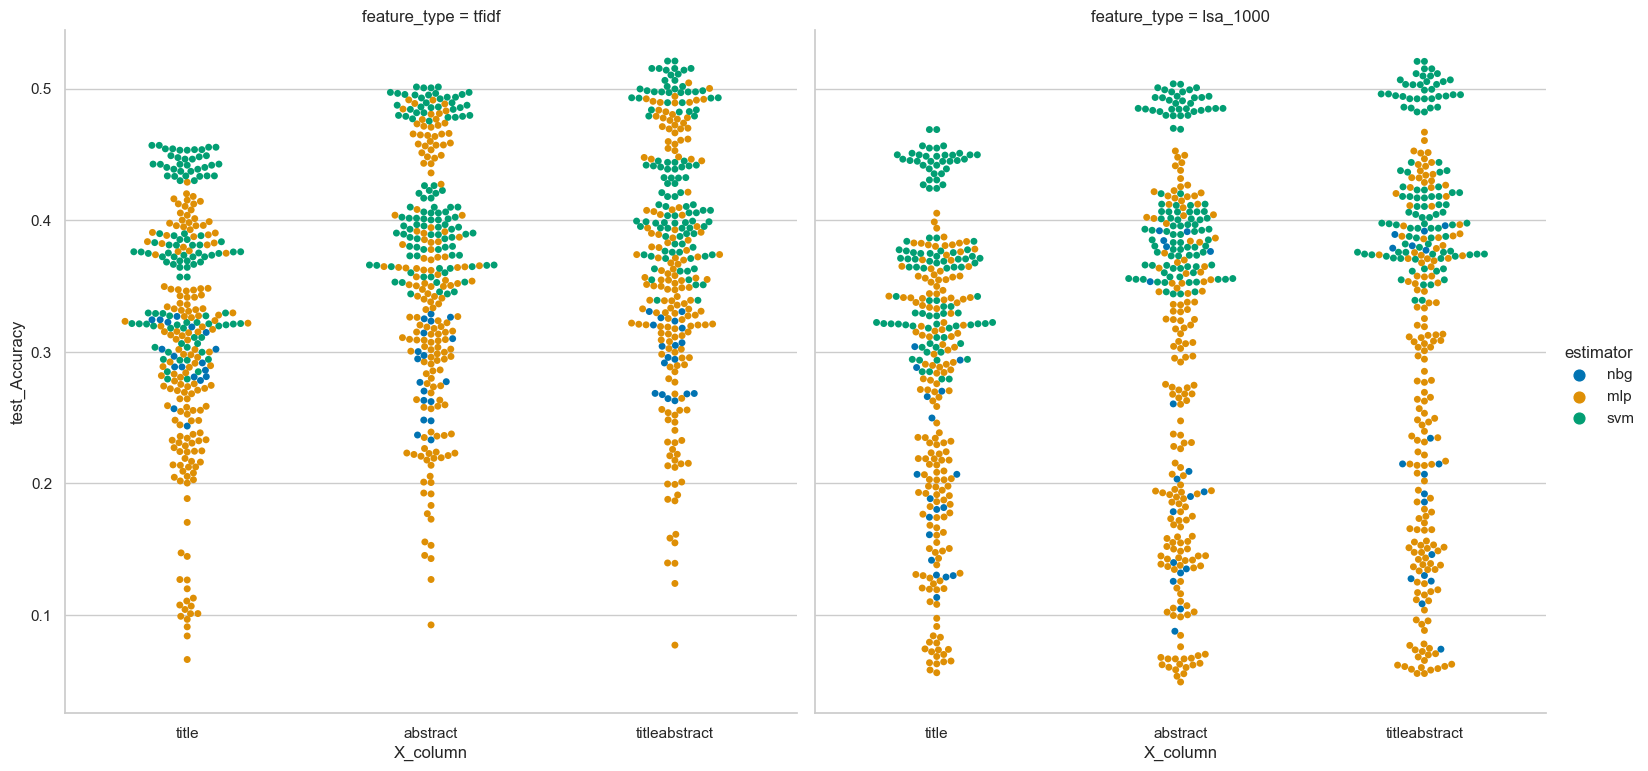

In [6]:
x = 'X_column'
ranking('catplot', kind=kind, data=data, y=y, x=x, hue=x)
ranking('catplot', kind=kind, data=data, y=y, x=x, hue='estimator')
ranking('catplot', kind=kind, data=data, y=y, x=x, hue='estimator', col='feature_type')

### Stop-words retiradas dinamicamente com base na frequência

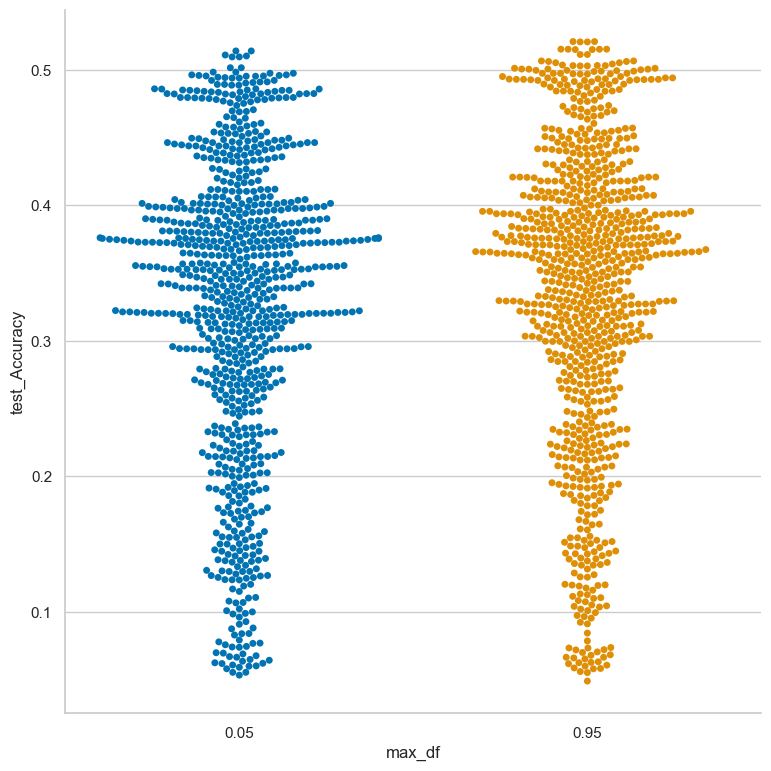

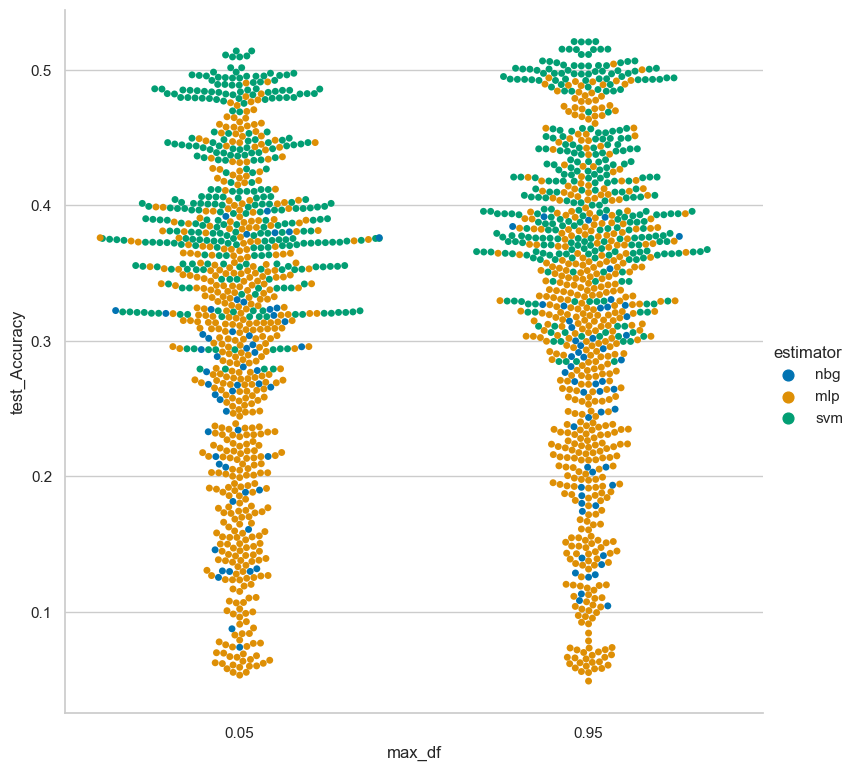

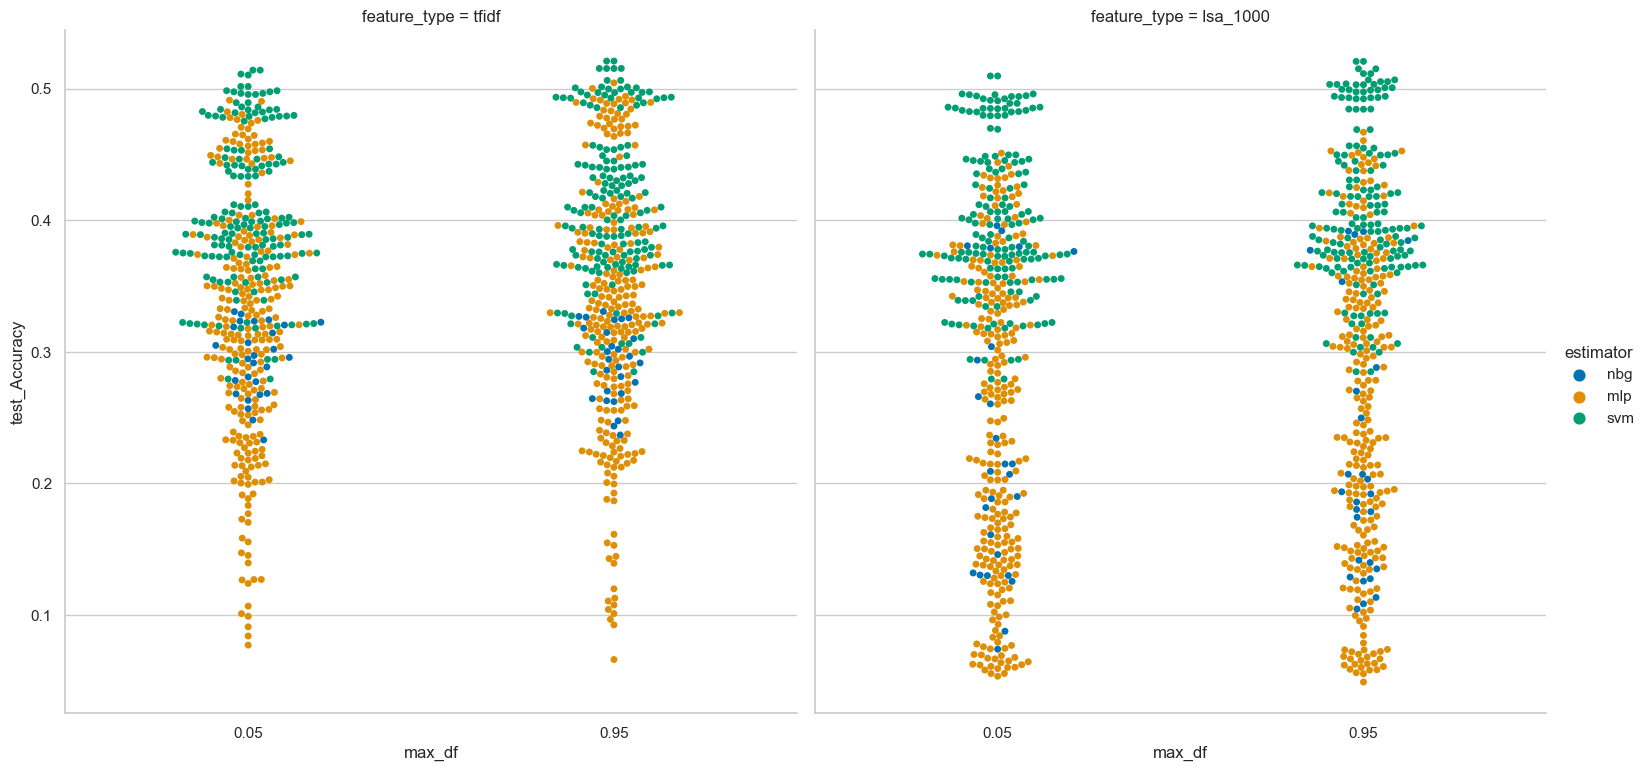

In [7]:
x = 'max_df'
ranking('catplot', kind=kind, data=data, y=y, x=x, hue=x)
ranking('catplot', kind=kind, data=data, y=y, x=x, hue='estimator')
ranking('catplot', kind=kind, data=data, y=y, x=x, hue='estimator', col='feature_type')

## Experimento - Estimadores

### Tipo de extração de features (TF-IDF ou TF-IDF+LSA)

In [1]:
x = 'feature_type'
ranking('catplot', kind=kind, data=results, y=y, x=x, hue=x)
ranking('catplot', kind=kind, data=results, y=y, x=x, hue='estimator')
ranking('catplot', kind=kind, data=results, y=y, x=x, hue='estimator', col='max_df')

NameError: name 'ranking' is not defined

### Algoritmo (NBG, MLP ou SVM)

#### Análise de tempos

##### Treinamento

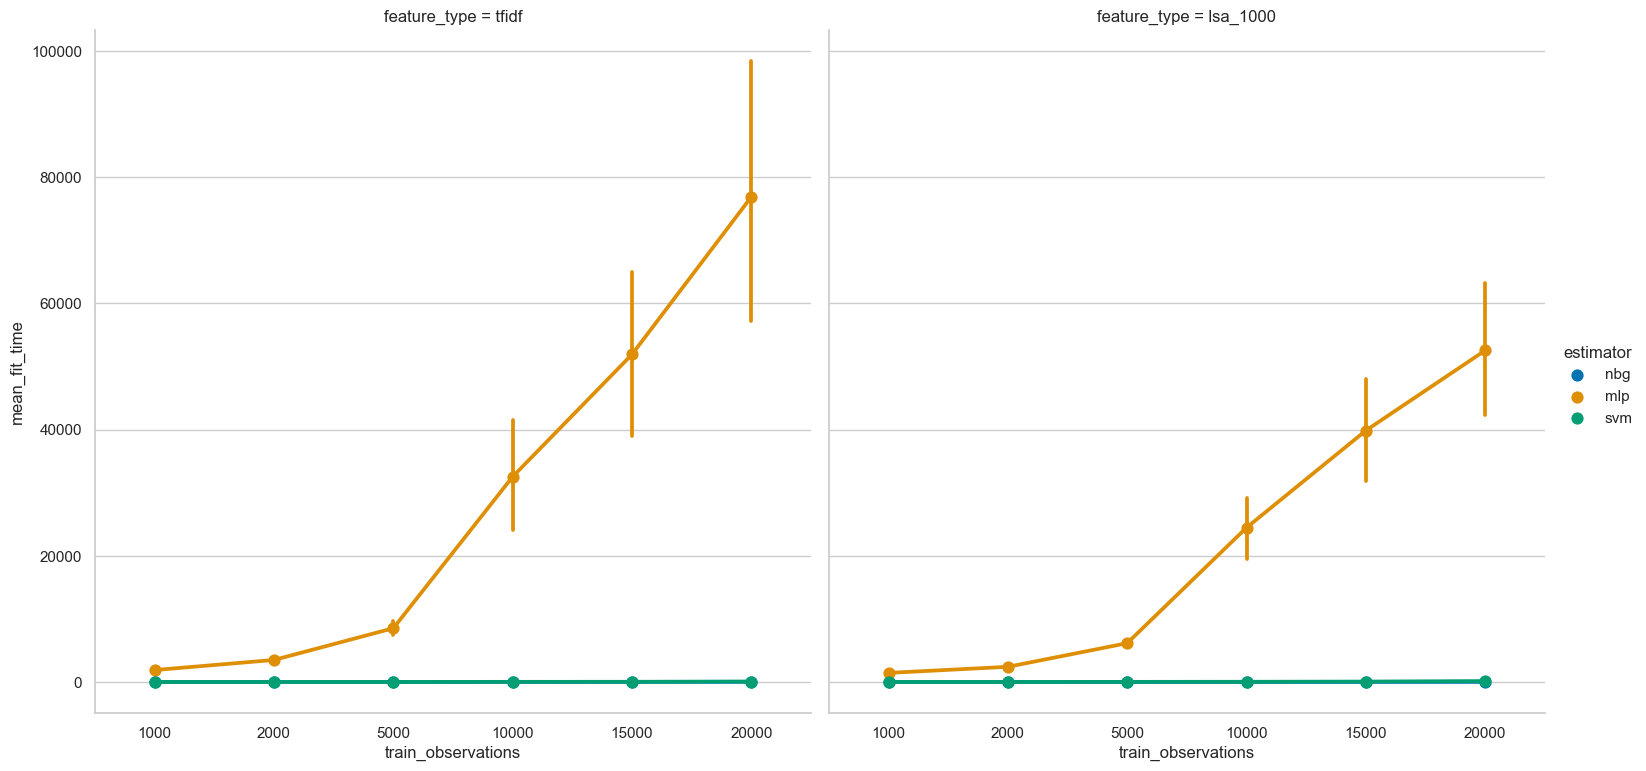

In [9]:
y = 'mean_fit_time'
x = 'train_observations'
ranking('catplot', kind='point', data=results, y=y, x=x, hue='estimator', col='feature_type')

##### Previsão

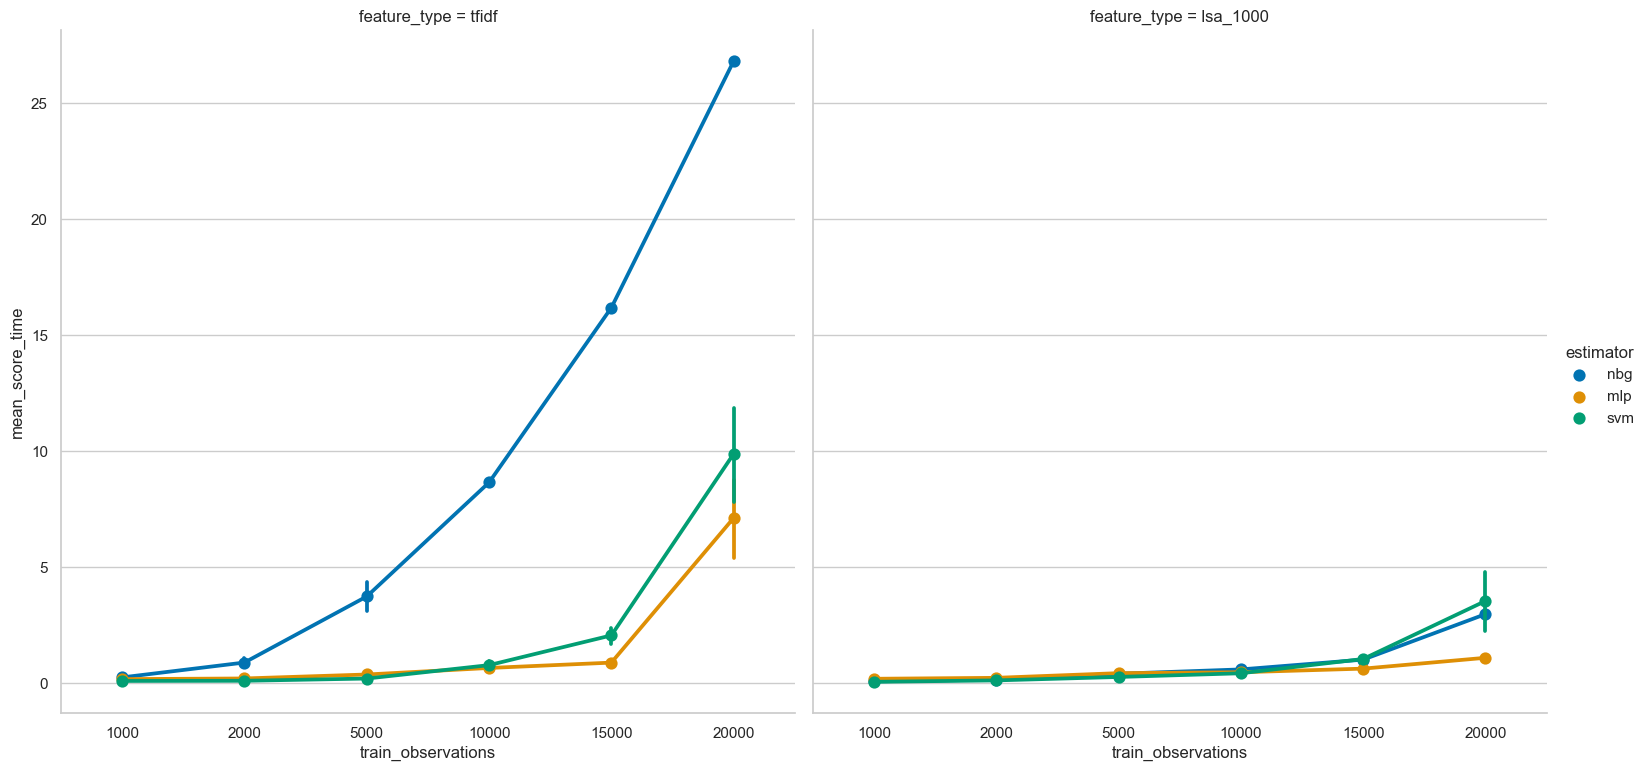

In [10]:
y = 'mean_score_time'
x = 'train_observations'
ranking('catplot', kind='point', data=results, y=y, x=x, hue='estimator', col='feature_type')

#### Desempenho

##### Acurácia

###### test_Accuracy

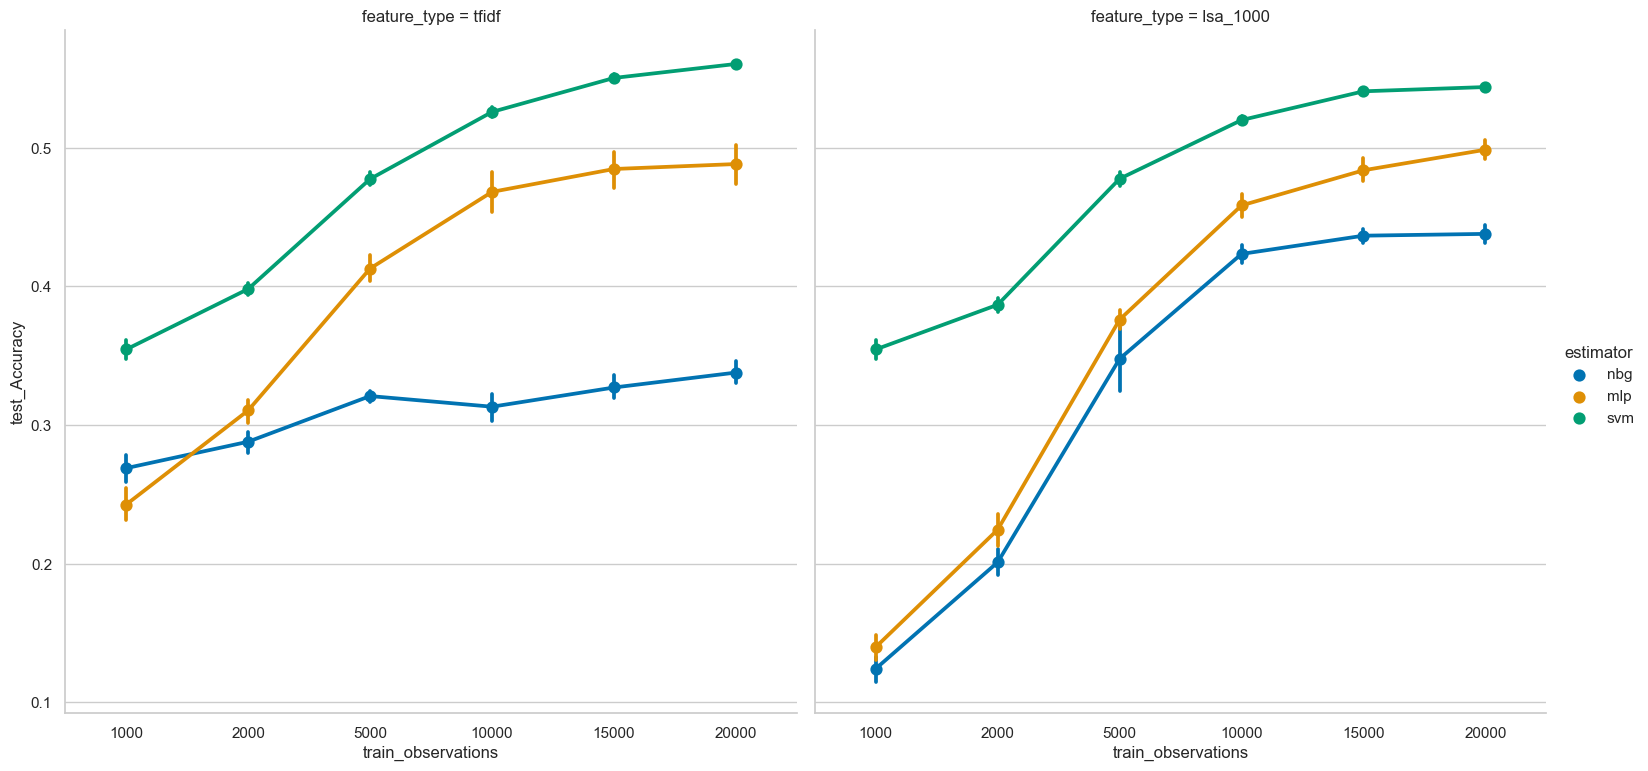

In [11]:
y = 'test_Accuracy'
ranking('catplot', kind='point', data=results, y=y, x=x, hue='estimator', col='feature_type')

###### mean_Accuracy

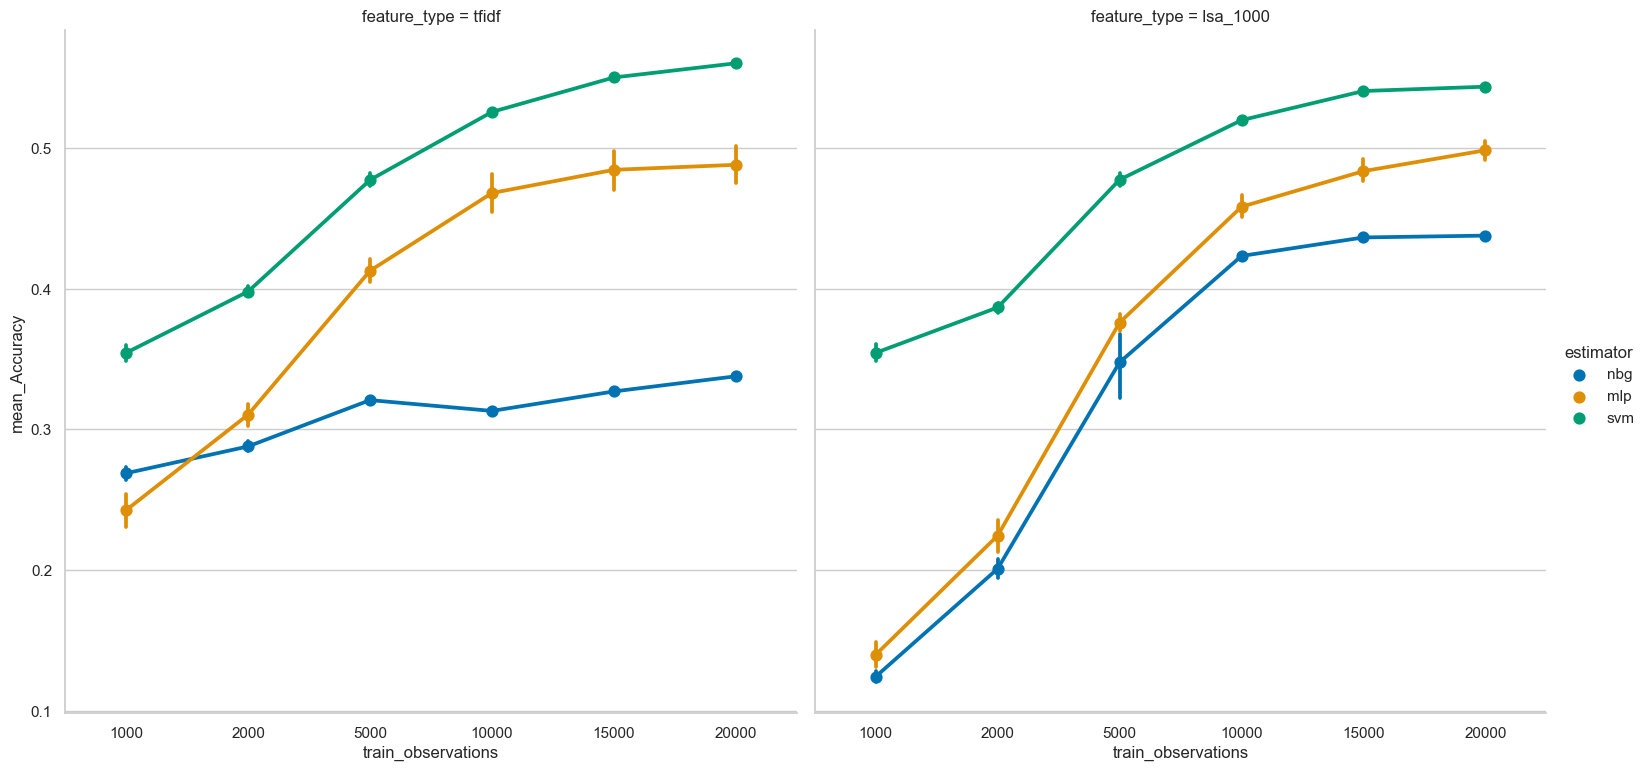

In [12]:
y = 'mean_Accuracy'
ranking('catplot', kind='point', data=results, y=y, x=x, hue='estimator', col='feature_type')

###### validated_mean_Accuracy

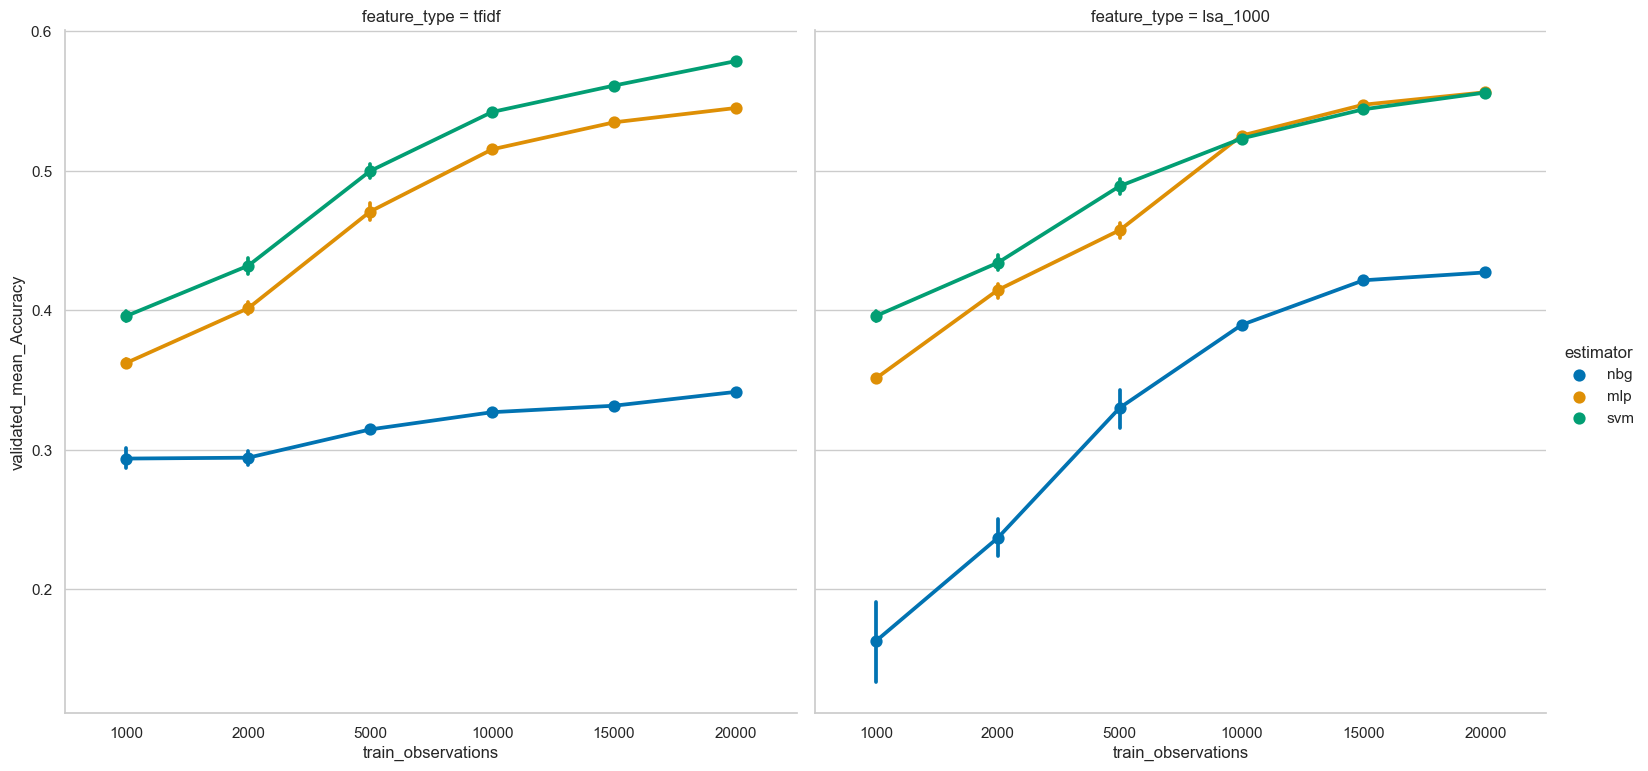

In [13]:
y = 'validated_mean_Accuracy'
ranking('catplot', kind='point', data=results, y=y, x=x, hue='estimator', col='feature_type')

##### F1score

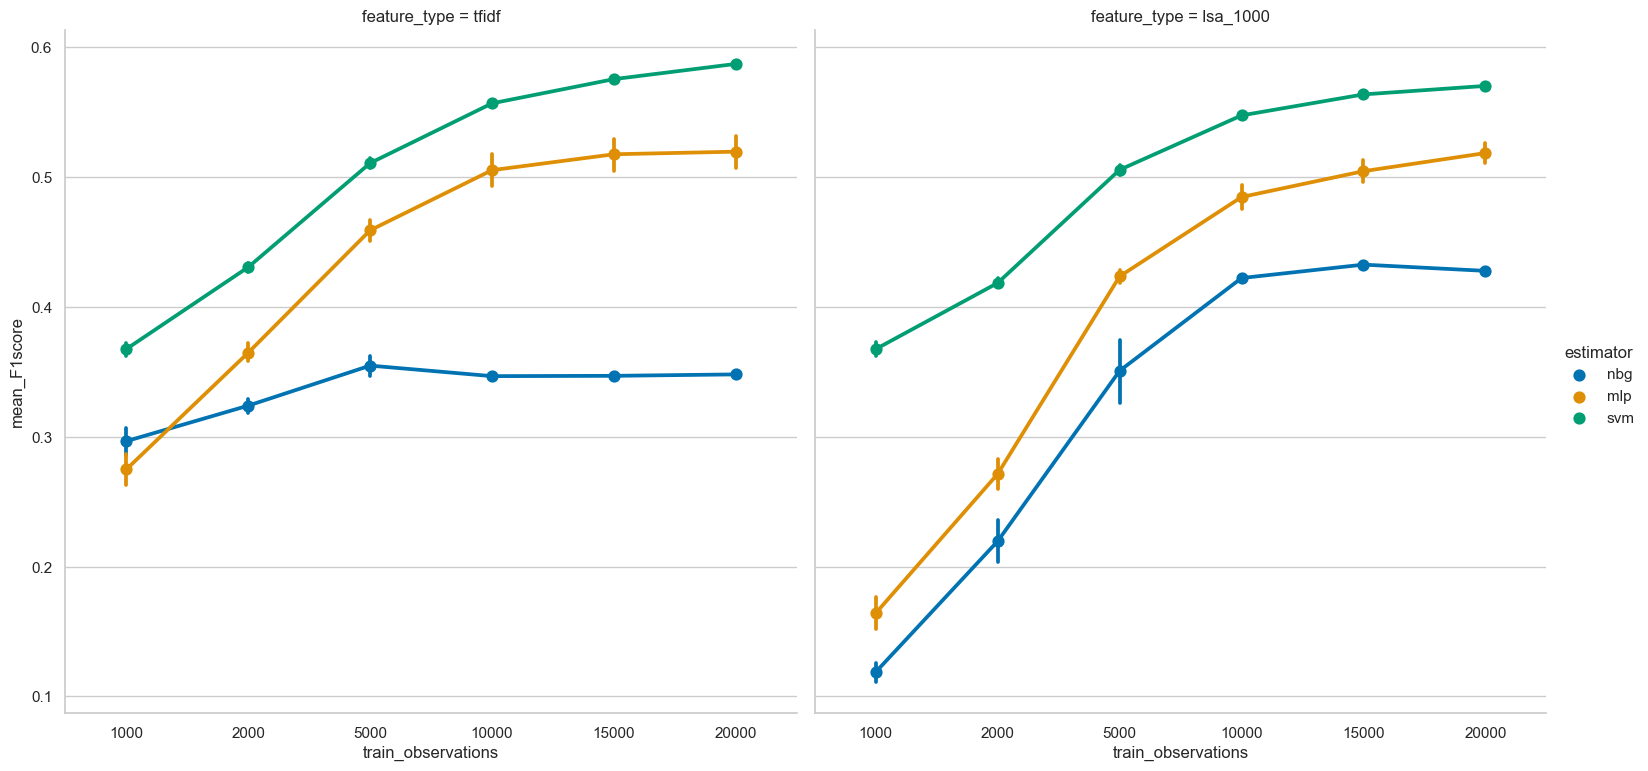

In [14]:
y = 'mean_F1score'
ranking('catplot', kind='point', data=results, y=y, x=x, hue='estimator', col='feature_type')

##### Precisão

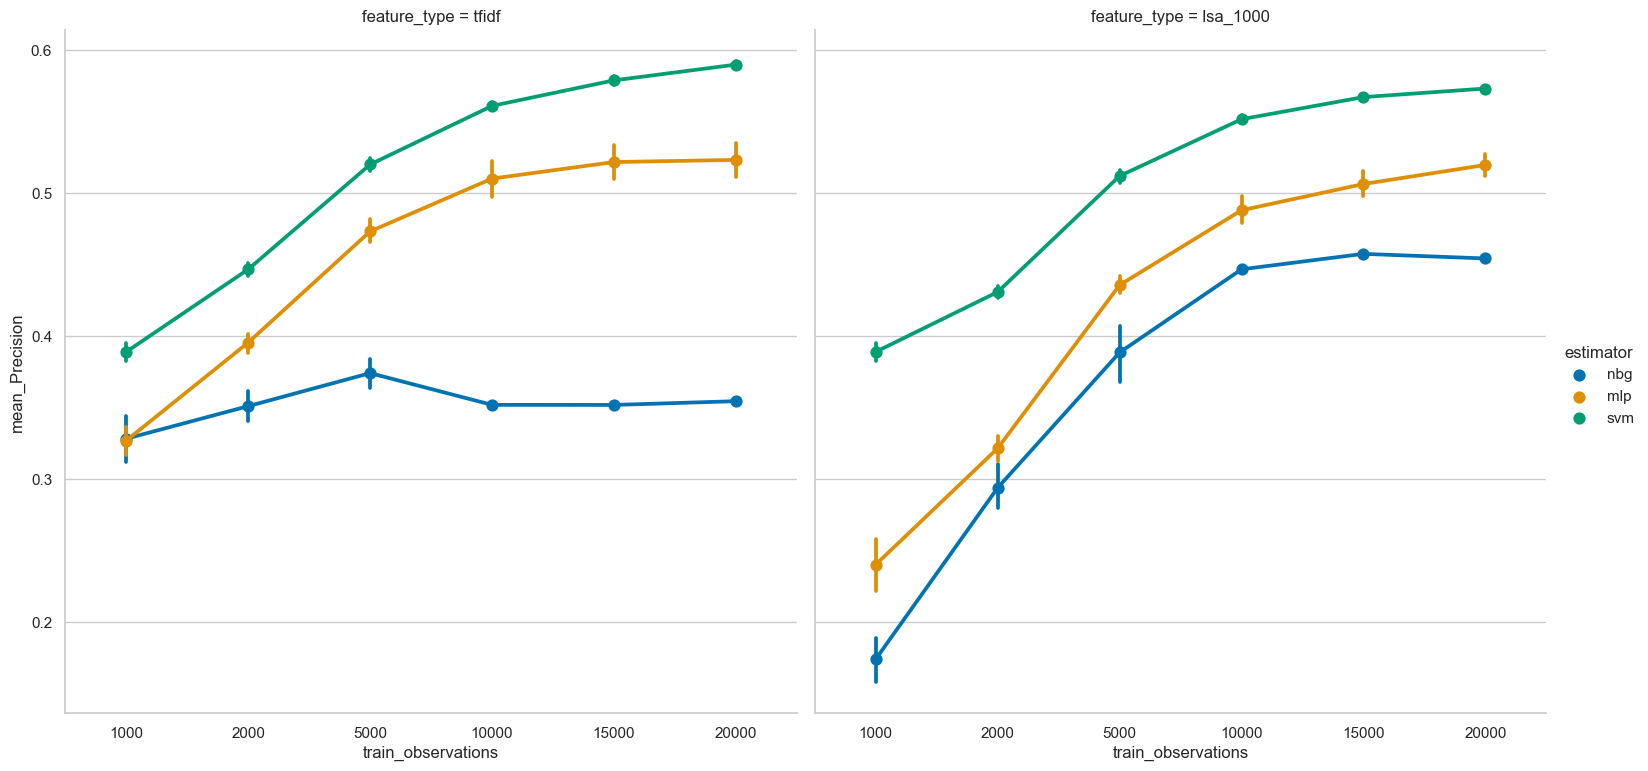

In [15]:
y = 'mean_Precision'
ranking('catplot', kind='point', data=results, y=y, x=x, hue='estimator', col='feature_type')

##### Recuperação

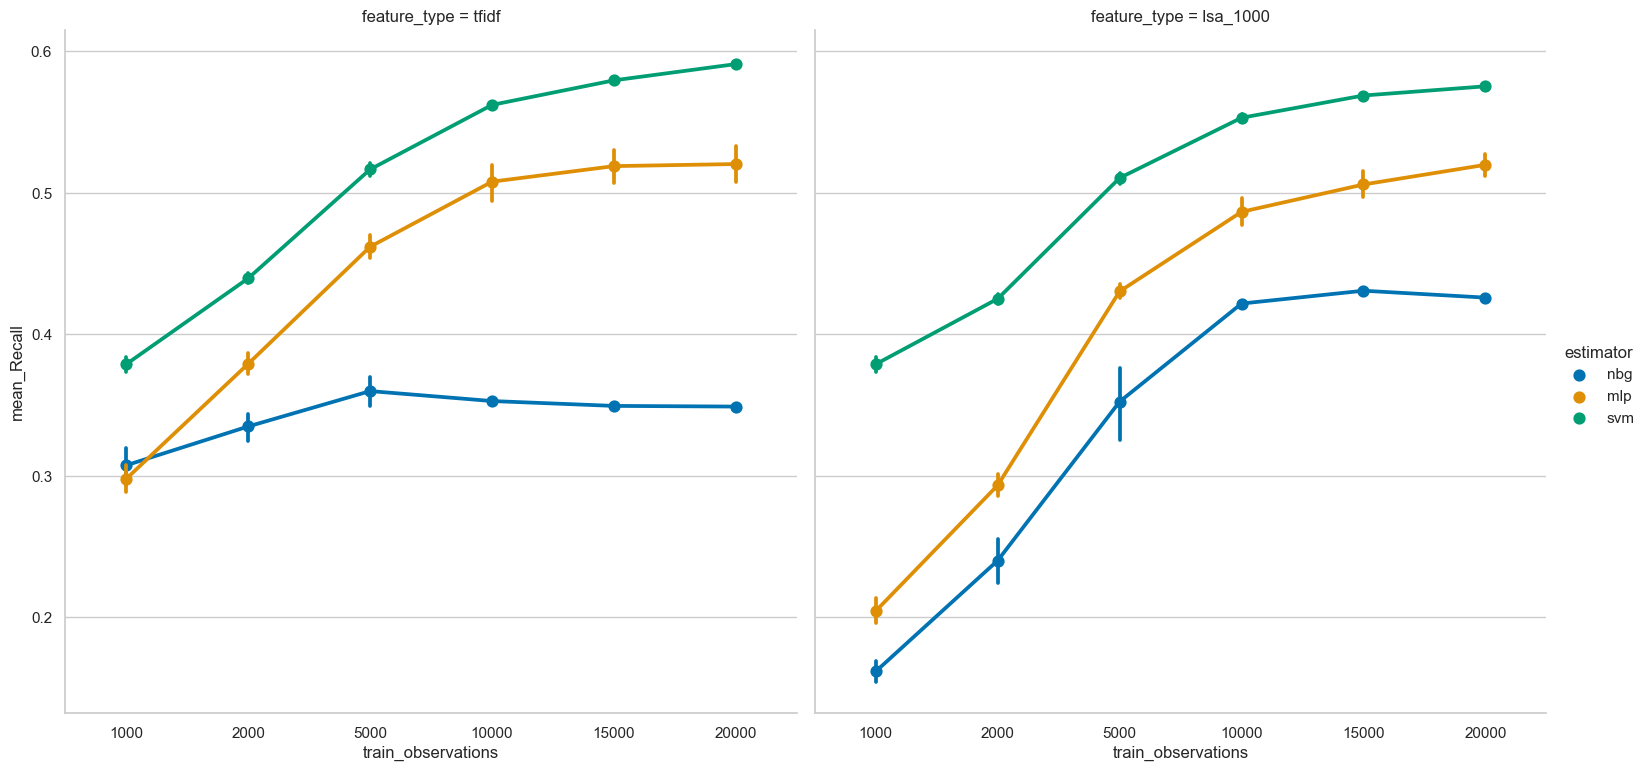

In [16]:
y = 'mean_Recall'
ranking('catplot', kind='point', data=results, y=y, x=x, hue='estimator', col='feature_type')

### Melhor combinação de hiper-parâmetros

#### Naïve-Bayes Gaussiano

In [17]:
# NBG
data.loc[data['estimator'] == 'nbg', [
    'estimator', 'train_observations', 
    'feature_type', 'X_column', 
    'hyperparams', 'mean_fit_time', 
    'validated_mean_Accuracy']].drop_duplicates(
).sort_values(['validated_mean_Accuracy', 'mean_fit_time'], ascending=[False, True])[:3]


,estimator,train_observations,feature_type,X_column,hyperparams,mean_fit_time,validated_mean_Accuracy
1680,nbg,5000,lsa_1000,titleabstract,{},0.654246,0.366229
1632,nbg,5000,lsa_1000,titleabstract,{},0.682887,0.359211
1584,nbg,5000,lsa_1000,abstract,{},0.722370,0.342131


#### Multi-layer Perceptron

In [18]:
# MLP
data.loc[data['estimator'] == 'mlp', [
    'estimator', 'train_observations', 
    'feature_type', 'X_column', 
    'hyperparams', 'mean_fit_time', 
    'validated_mean_Accuracy']].drop_duplicates(
).sort_values(['validated_mean_Accuracy', 'mean_fit_time'], ascending=[False, True])[:5]


,estimator,train_observations,feature_type,X_column,hyperparams,mean_fit_time,validated_mean_Accuracy
1347,mlp,5000,tfidf,titleabstract,"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50, 19), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 2000, 'solver': 'adam'}",1601.775023,0.509671
1365,mlp,5000,tfidf,titleabstract,"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 2000, 'solver': 'adam'}",1851.465650,0.509671
1356,mlp,5000,tfidf,titleabstract,"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 2000, 'solver': 'adam'}",2572.110446,0.509671
1350,mlp,5000,tfidf,titleabstract,"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50, 19), 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001, 'max_iter': 2000, 'solver': 'adam'}",5868.297189,0.509671
1368,mlp,5000,tfidf,titleabstract,"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001, 'max_iter': 2000, 'solver': 'adam'}",6421.081204,0.509671


#### Support Vector Machine

In [19]:
# SVM
data.loc[data['estimator'] == 'svm', [
    'estimator', 'train_observations', 
    'feature_type', 'X_column', 
    'hyperparams', 'mean_fit_time', 
    'validated_mean_Accuracy']].drop_duplicates(
).sort_values(['validated_mean_Accuracy', 'mean_fit_time'], ascending=[False, True])[:5]


,estimator,train_observations,feature_type,X_column,hyperparams,mean_fit_time,validated_mean_Accuracy
1386,svm,5000,tfidf,titleabstract,"{'C': 1.5, 'dual': True, 'multi_class': 'ovr', 'random_state': 8637, 'tol': 0.0001}",2.098852,0.53366
1380,svm,5000,tfidf,titleabstract,"{'C': 1.0, 'dual': True, 'multi_class': 'ovr', 'random_state': 8637, 'tol': 0.0001}",2.160628,0.53366
1374,svm,5000,tfidf,titleabstract,"{'C': 0.5, 'dual': True, 'multi_class': 'ovr', 'random_state': 8637, 'tol': 0.0001}",2.261624,0.53366
1377,svm,5000,tfidf,titleabstract,"{'C': 0.5, 'dual': False, 'multi_class': 'ovr', 'random_state': 8637, 'tol': 0.0001}",3.519469,0.53366
1383,svm,5000,tfidf,titleabstract,"{'C': 1.0, 'dual': False, 'multi_class': 'ovr', 'random_state': 8637, 'tol': 0.0001}",3.741470,0.53366


## BERT

Find best Learning Rate

In [20]:
x = 'learning_rate'
hue = 'n_samples'

### Acurácia

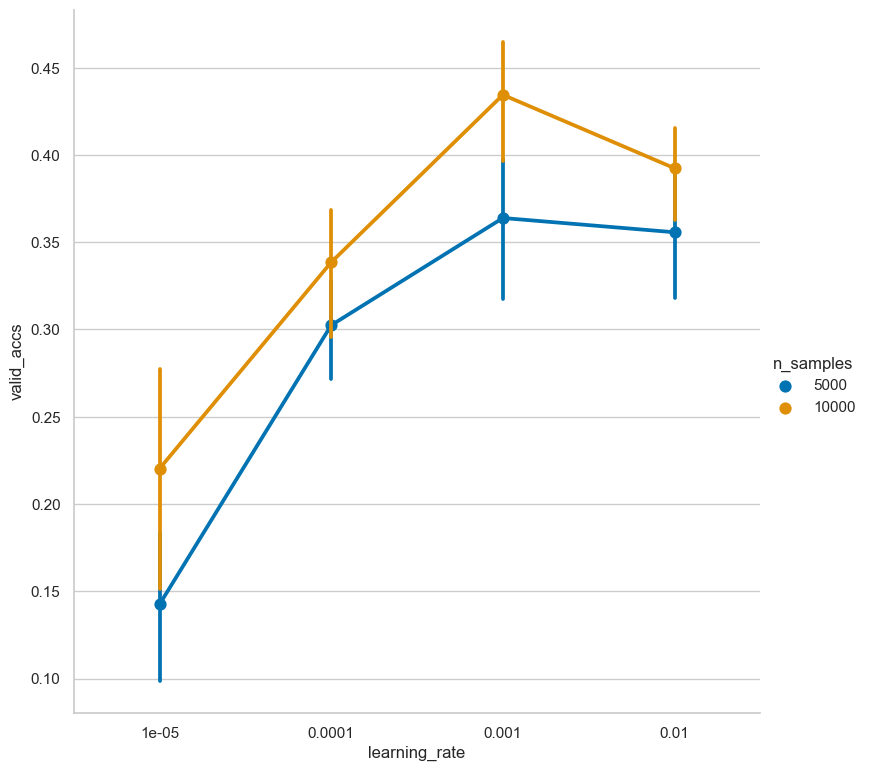

In [21]:
y = 'valid_accs'
ranking('catplot', kind='point', data=bert_results, y=y, x=x, hue=hue)

### Erro

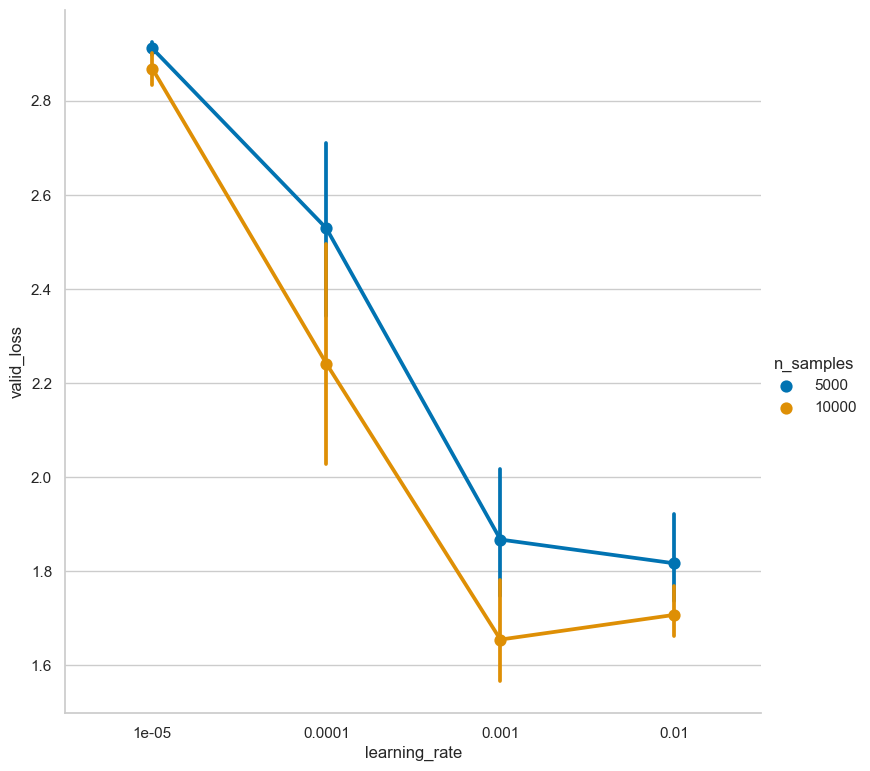

In [22]:
y = 'valid_loss'
ranking('catplot', kind='point', data=bert_results, y=y, x=x, hue=hue)

## Todos os valores médios

In [23]:
# Complete General View by validated_mean_Accuracy
summary[["X_column", "train_observations", "estimator", "feature_type", "max_df", "hyperparams", 
         "mean_Accuracy", "validated_mean_Accuracy",
         "mean_F1score", "validated_f1score_weighted"]].groupby(["train_observations", "X_column", "estimator", 
                                                                 "feature_type", "max_df"]).max()[:4]

hyperparams  \
train_observations X_column estimator feature_type max_df                                                                                                                                                                               
1000               abstract mlp       lsa_1000     0.05    {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50, 19), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 2000, 'solver': 'adam'}   
                                                   0.95    {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50, 19), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 2000, 'solver': 'adam'}   
                                      tfidf        0.05    {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50, 19), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 2000, 'solver': 'adam'}   
                                                   0.95    {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50, 19), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 2000, 'solver': 'adam'}   

                                                           mean_Accuracy  \
train_observations X_column estimator feature_type max_df                  
1000               abstract mlp       lsa_1000     0.05    0.159114        
                                                   0.95    0.141605        
                                      tfidf        0.05    0.238628        
                                                   0.95    0.238757        

                                                           validated_mean_Accuracy  \
train_observations X_column estimator feature_type max_df                            
1000               abstract mlp       lsa_1000     0.05    0.340593                  
                                                   0.95    0.367474                  
                                      tfidf        0.05    0.368134                  
                                                   0.95    0.361586                  

                                                           mean_F1score  \
train_observations X_column estimator feature_type max_df                 
1000               abstract mlp       lsa_1000     0.05    0.164313       
                                                   0.95    0.169352       
                                      tfidf        0.05    0.251738       
                                                   0.95    0.260639       

                                                           validated_f1score_weighted  
train_observations X_column estimator feature_type max_df                              
1000               abstract mlp       lsa_1000     0.05    0.396073                    
                                                   0.95    0.428466                    
                                      tfidf        0.05    0.407698                    
                                                   0.95    0.421302

### Valores test_ por estimador

In [24]:
select_nbg = results[results['estimator'] == 'nbg']
print(f'Todos os valores test_ para NBG: {select_nbg.shape}')

Todos os valores test_ para NBG: (138, 29)


In [25]:
select_mlp = results[results['estimator'] == 'mlp']
print(f'Todos os valores test_ para NBG: {select_mlp.shape}')

Todos os valores test_ para NBG: (1242, 29)


In [26]:
select_svm = results[results['estimator'] == 'svm']
print(f'Todos os valores test_ para NBG: {select_svm.shape}')

Todos os valores test_ para NBG: (828, 29)


In [27]:
select_nbg.shape[0] + select_mlp.shape[0] + select_svm.shape[0]

2208